In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.feature_selection import RFE
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()
test.head()
train.shape
test.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


(891, 12)

(418, 11)

In [5]:
train.PassengerId.value_counts()
train.Sex.value_counts()
train.Pclass.value_counts()
train.Name.value_counts()
train.Embarked.value_counts()
train.Cabin.value_counts()
train.SibSp.value_counts()
train.Ticket.value_counts()
train.Parch.value_counts()
train.Fare.value_counts()
train.Age.value_counts()

891    1
293    1
304    1
303    1
302    1
      ..
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

3    491
1    216
2    184
Name: Pclass, dtype: int64

Peduzzi, Mr. Joseph              1
Nankoff, Mr. Minko               1
Beesley, Mr. Lawrence            1
Hamalainen, Master. Viljo        1
Ayoub, Miss. Banoura             1
                                ..
McCarthy, Mr. Timothy J          1
Maisner, Mr. Simon               1
Silvey, Mr. William Baird        1
Futrelle, Mr. Jacques Heath      1
Sawyer, Mr. Frederick Charles    1
Name: Name, Length: 891, dtype: int64

S    644
C    168
Q     77
Name: Embarked, dtype: int64

G6             4
B96 B98        4
C23 C25 C27    4
D              3
F2             3
              ..
E40            1
D9             1
E31            1
D50            1
C87            1
Name: Cabin, Length: 147, dtype: int64

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

CA. 2343    7
1601        7
347082      7
3101295     6
CA 2144     6
           ..
349243      1
7540        1
11771       1
341826      1
315151      1
Name: Ticket, Length: 681, dtype: int64

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

# Name and PassengerId are removed since they both are unique and ticket is removed since it has no affect on survived

In [6]:
train = train.drop(['PassengerId'], axis=1)
train = train.drop(['Name'], axis=1)
train = train.drop(['Ticket'], axis=1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [7]:
train['Sex'] = train['Sex'].apply(lambda x: 0 if x == 'male' else 1)
for i in train['Pclass']:
    if i == 1:
        train['Pclass'] = train['Pclass'].replace(i, 'Upper')
        
    elif i == 2:
        train['Pclass'] = train['Pclass'].replace(i, 'Middle')

    else:
        train['Pclass'] = train['Pclass'].replace(i, 'Lower')
        
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,Lower,0,22.0,1,0,7.2500,NaN,S
1,1,Upper,1,38.0,1,0,71.2833,C85,C
2,1,Lower,1,26.0,0,0,7.9250,NaN,S
3,1,Upper,1,35.0,1,0,53.1000,C123,S
4,0,Lower,0,35.0,0,0,8.0500,NaN,S


In [8]:
train.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Cabin        True
Embarked     True
dtype: bool

In [9]:
train.Cabin.isnull().sum()
train.Embarked.isnull().sum()
train.Age.isnull().sum()

687

2

177

# Too many missing values for Cabin. This feature is not useful so performing column-wise deletion

In [10]:
train = train.drop(['Cabin'], axis=1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,Lower,0,22.0,1,0,7.2500,S
1,1,Upper,1,38.0,1,0,71.2833,C
2,1,Lower,1,26.0,0,0,7.9250,S
3,1,Upper,1,35.0,1,0,53.1000,S
4,0,Lower,0,35.0,0,0,8.0500,S


# Drop duplicates

In [11]:
train = train.drop_duplicates()
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,Lower,0,22.0,1,0,7.2500,S
1,1,Upper,1,38.0,1,0,71.2833,C
2,1,Lower,1,26.0,0,0,7.9250,S
3,1,Upper,1,35.0,1,0,53.1000,S
4,0,Lower,0,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,Lower,1,39.0,0,5,29.1250,Q
887,1,Upper,1,19.0,0,0,30.0000,S
888,0,Lower,1,NaN,1,2,23.4500,S
889,1,Upper,0,26.0,0,0,30.0000,C


# Row-wise deletion for missing Embarked feature

In [12]:
train = train.dropna(subset=['Embarked', 'Age'])
train.Age.fillna(train.Age.mean())
train.isnull().any()

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
883    28.0
885    39.0
887    19.0
889    26.0
890    32.0
Name: Age, Length: 674, dtype: float64

Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

In [13]:
train.head()
train.shape

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,Lower,0,22.0,1,0,7.2500,S
1,1,Upper,1,38.0,1,0,71.2833,C
2,1,Lower,1,26.0,0,0,7.9250,S
3,1,Upper,1,35.0,1,0,53.1000,S
4,0,Lower,0,35.0,0,0,8.0500,S


(674, 8)

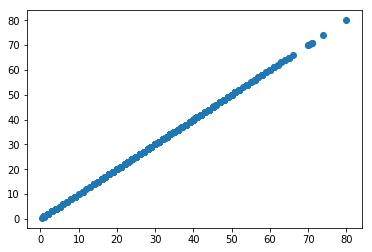

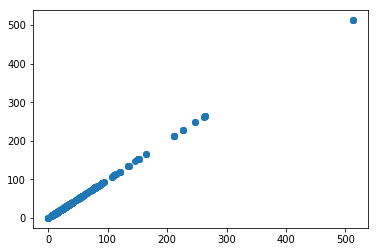

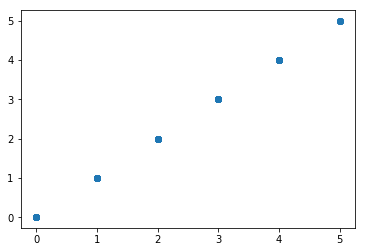

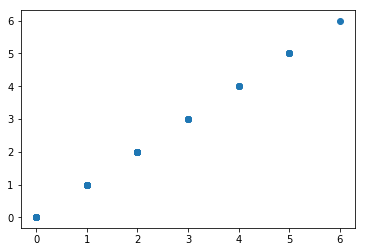

In [14]:
plt.scatter(x = train['Age'], y=train['Age'])
plt.show()
plt.scatter(x = train['Fare'], y=train['Fare'])
plt.show()
plt.scatter(x = train['SibSp'], y=train['SibSp'])
plt.show()
plt.scatter(x = train['Parch'], y=train['Parch'])
plt.show()

# Remove outliers

In [15]:
train = train[train.Fare < 300]
train.shape

(671, 8)

# One hot encode variables

In [16]:
train = pd.get_dummies(train, columns=['Pclass', 'Embarked', 'SibSp', 'Parch'])
train.head()

,Survived,Sex,Age,Fare,Pclass_Lower,Pclass_Middle,Pclass_Upper,Embarked_C,Embarked_Q,Embarked_S,...,SibSp_3,SibSp_4,SibSp_5,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0,22.0,7.2500,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,1,38.0,71.2833,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,26.0,7.9250,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,35.0,53.1000,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,35.0,8.0500,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [17]:
train.Age = train.Age.astype(int)
train.Fare = train.Fare.astype(int)
train.head()

,Survived,Sex,Age,Fare,Pclass_Lower,Pclass_Middle,Pclass_Upper,Embarked_C,Embarked_Q,Embarked_S,...,SibSp_3,SibSp_4,SibSp_5,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0,22,7,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,1,38,71,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,26,7,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,35,53,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,35,8,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


# Drop features that are linearly dependent of each other

In [18]:
train = train.drop(['Pclass_Lower'], axis=1)
train = train.drop(['Embarked_C'], axis=1)

train.head()

,Survived,Sex,Age,Fare,Pclass_Middle,Pclass_Upper,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,...,SibSp_3,SibSp_4,SibSp_5,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0,22,7,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,1,38,71,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,1,26,7,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,35,53,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,35,8,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0


In [19]:
train.SibSp_1
train.SibSp_2

0      1
1      1
2      0
3      1
4      0
      ..
883    0
885    0
887    0
889    0
890    0
Name: SibSp_1, Length: 671, dtype: uint8

0      0
1      0
2      0
3      0
4      0
      ..
883    0
885    0
887    0
889    0
890    0
Name: SibSp_2, Length: 671, dtype: uint8

In [20]:
train = train.drop(['SibSp_0'], axis=1)
train.head(20)

,Survived,Sex,Age,Fare,Pclass_Middle,Pclass_Upper,Embarked_Q,Embarked_S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0,22,7,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,1,1,38,71,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1,1,26,7,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,1,1,35,53,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,35,8,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,54,51,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
7,0,0,2,21,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
8,1,1,27,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
9,1,1,14,30,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
10,1,1,4,16,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0


In [21]:
train = train.drop_duplicates()
train.shape

(616, 20)

In [22]:
train.head(20)

,Survived,Sex,Age,Fare,Pclass_Middle,Pclass_Upper,Embarked_Q,Embarked_S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0,22,7,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,1,1,38,71,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1,1,26,7,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,1,1,35,53,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,35,8,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,54,51,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
7,0,0,2,21,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
8,1,1,27,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
9,1,1,14,30,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
10,1,1,4,16,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0


# Build models

0    345
1    271
Name: Survived, dtype: int64

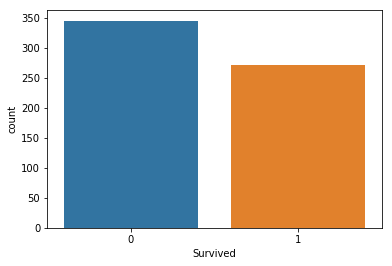

In [23]:
sns.countplot(train.Survived)
train.Survived.value_counts()

In [24]:
features = ['Age', 'Embarked_Q', 'Embarked_S', 'Fare', 'Parch_0', 'Pclass_Middle', 'Pclass_Upper', 'Sex', 'SibSp_1', 
            'SibSp_2', 'Parch_1', 'Parch_2', 'SibSp_4', 'SibSp_3', 'SibSp_5', 'Parch_4', 'Parch_3', 'Parch_5', 'Parch_6', 'Survived']
train = train[features]
X = train.drop(['Survived'], axis=1)
Y = train['Survived']

In [25]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=0)

# Random Forest Model

In [26]:
rf = RandomForestClassifier()
rf.fit(train_features, train_labels)
rf_pred_train = rf.predict(train_features)
rf_pred_test = rf.predict(test_features)
print(classification_report(test_labels,rf_pred_test))
print('Random Forest baseline: ' + str(roc_auc_score(train_labels, rf_pred_train)))
print('Random Forest: ' + str(roc_auc_score(test_labels, rf_pred_test)))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       0.69      0.81      0.74        68
           1       0.70      0.55      0.62        56

    accuracy                           0.69       124
   macro avg       0.70      0.68      0.68       124
weighted avg       0.70      0.69      0.69       124

Random Forest baseline: 0.9444631013349004
Random Forest: 0.6811974789915967


# Hyper parameter tuning and feature selection

In [27]:
rf = RandomForestClassifier()
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10],
    'min_samples_leaf': [3],
    'n_estimators': [1000],
    'oob_score': [True],
    'random_state': [0],
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(train_features, train_labels);

grid_search.best_params_
best_grid = grid_search.best_estimator_
pprint(best_grid.get_params())

selector = RFE(rf, step=1, verbose=3)
selector = selector.fit(train_features, train_labels)
print("Features sorted by their rank:")
pprint(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), X)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

{'max_depth': 10,
 'min_samples_leaf': 3,
 'n_estimators': 1000,
 'oob_score': True,
 'random_state': 0}

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Features sorted by their rank:
[(1, 'Age'),
 (1, 'Embarked_S'),
 (1, 'Fare'),
 (1, 'Parch_0'),
 (1, 'Parch_1'),
 (1, 'Pclass_Middle'),
 (1, 'Pclass_Upper'),
 (1, 'Sex'),
 (1, 'SibSp_1'),
 (2, 'Parch_2'),
 (3, 'SibSp_4'),
 (4, 'SibSp_3'),
 (5, 'Embarked_Q'),
 (6, 'SibSp_2'),
 (7, 'SibSp_5'),
 (8, 'Parch_4'),
 (9, 'Parch_3'),
 (10, 'Parch_5'),
 (11, 'Parch_6')]


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
rf = RandomForestClassifier(**best_grid.get_params())
rf.fit(train_features, train_labels)
rf_pred_train = rf.predict(train_features)
rf_pred_test = rf.predict(test_features)
print(classification_report(test_labels,rf_pred_test))
print('Random Forest baseline: ' + str(roc_auc_score(train_labels, rf_pred_train)))
print('Random Forest: ' + str(roc_auc_score(test_labels, rf_pred_test)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

           0       0.70      0.84      0.77        68
           1       0.74      0.57      0.65        56

    accuracy                           0.72       124
   macro avg       0.72      0.70      0.71       124
weighted avg       0.72      0.72      0.71       124

Random Forest baseline: 0.855083536227017
Random Forest: 0.7048319327731092


# Neural Network

In [29]:
model = Sequential()
model.add(Dense(12, input_dim=19, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_features, train_labels)
model_pred_train = model.predict(train_features)
model_pred_test = model.predict(test_features)
print(classification_report(test_labels,rf_pred_test))
print('Neural Network baseline: ' + str(roc_auc_score(train_labels, model_pred_train)))
print('Neural Network: ' + str(roc_auc_score(test_labels, model_pred_test)))

Epoch 1/1
492/492 [==============================] - 0s 601us/step - loss: 21.1277 - accuracy: 0.4370


              precision    recall  f1-score   support

           0       0.70      0.84      0.77        68
           1       0.74      0.57      0.65        56

    accuracy                           0.72       124
   macro avg       0.72      0.70      0.71       124
weighted avg       0.72      0.72      0.71       124

Neural Network baseline: 0.457157249601209
Neural Network: 0.5129989495798319


In [30]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(1, input_dim=19, kernel_initializer='normal', activation='tanh', kernel_constraint=maxnorm(2)))
    model.add(Dropout(0.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    optimizer = optimizers.adam(lr=.001)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=100, batch_size=10)
# define the grid search parameters
param_grid = {
#     'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#     'batch_size': [10, 20, 40, 60, 80, 100],
#     'epochs': [10, 50, 100],
#     'learn_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
#     'momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
#     'init_mode': ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
#     'activation': ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
#     'weight_constraint': [1, 2, 3, 4, 5],
#     'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#     'neurons': [1, 5, 10, 15, 20, 25, 30]
    
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

# Fit the grid search to the data
grid_result = grid_search.fit(train_features, train_labels);

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.4s finished


Best: 0.778455 using {}
0.778455 (0.010364) with: {}


In [31]:
model.fit(train_features, train_labels)
model_pred_train = model.predict(train_features)
model_pred_test = model.predict(test_features)
print(classification_report(test_labels,rf_pred_test))
print('Neural Network baseline: ' + str(roc_auc_score(train_labels, model_pred_train)))
print('Neural Network: ' + str(roc_auc_score(test_labels, model_pred_test)))

              precision    recall  f1-score   support

           0       0.70      0.84      0.77        68
           1       0.74      0.57      0.65        56

    accuracy                           0.72       124
   macro avg       0.72      0.70      0.71       124
weighted avg       0.72      0.72      0.71       124

Neural Network baseline: 0.7870120057090085
Neural Network: 0.7410714285714285
